# Imports

In [1]:
##############
# basic libs #
##############

import warnings
warnings.filterwarnings('ignore')
import os, sys, time, datetime, json, string, glob, re
from subprocess import call
from tqdm import *
from time import time

############
# plumbing #
############

from sqlalchemy import create_engine
from collections import OrderedDict
import urllib2, requests, operator, hashlib, uuid

###########
# science #
###########

from math import radians, cos, sin, asin, sqrt
import scipy as sp
import numpy as np
import pandas as pd

#######
# ML #
######

import pymc3 as pm
import theano as thno
import theano.tensor as T
from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search

#################
# visualization #
#################

# 3D
from IPython.html.widgets import interactive, fixed
from mpl_toolkits.mplot3d import Axes3D

# plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# seaborn
import seaborn as sns
sns.set(style="dark", palette="muted")
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

#graphistry
import graphistry
graphistry.register(key=os.environ.get('GRAPHISTRY_APIKEY'))

# pandas
#pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)

In [2]:
%reload_ext watermark

In [3]:
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,seaborn

Ken Cavagnolo 
Last updated: Wed Feb 10 2016 

CPython 2.7.10
IPython 4.0.3

numpy 1.10.4
scipy 0.17.0
pandas 0.17.1
seaborn 0.7.0

compiler   : GCC 5.2.1 20151010
system     : Linux
release    : 4.2.0-23-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : ubuntu
Git hash   : c2a31b3bf650872dcfaccf1c5483a7cea947dc76


# What's the problem?

* Informal: using Telstra's service logs, the task is to predict the severity of a network disruption.

* Describe the problem formally, e.g.
    * Task (T): For a specific time and location, classify network fault severity as 0 == no faults, 1 == few faults, 2 == many faults. Fault severity is a measurement of actual reported faults from users of the network and is the target variable.
    * Experience (E): Each row in the train/test data represents a location and a time point. They are identified by the "id" column, which is the key "id" used in the other data files (event_type, resource_type, severity_type, log_feature) that contain features extracted from log files and other sources. Note that severity_type:
        * Is a categorical feature extracted from the log files
        * "Often" (**when is it not?**) the type of the warning message coming from the log files
        * Does not have an ordering
    * Performance (P): Classification accuracy, the number of fault events predicted correctly (a set of predicted probabilities one for every fault severity mus be given) out of all faults considered as a percentage.

* Assumptions:
    * All given features will matter to the model.
    * The clustering in time and location matter to the model, but may be mutually exclusive.
    * The volume of faults may not matter to the model.
    * Systemic long duration, low-volume correlated faults could be hiding in data.

* Similar problems:
    * Airline loyalty and medallion class problem
    * Anomaly detection, e.g. [Twitter's R package](https://github.com/nicolasmiller/pyculiarity)

# How to approach the problem?

* Brainstorm! Literally type everything as a stream of consciousness (coffee helps here)

These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts.

* Describe how to solve problem manually
* What data do I have?
* What data do I need?
* What data I **don't** need?
* What do I know the least about in the solution process above?
    * knowledge gap 1
    * knowledge gap 2
* What am I concerned is incorrect in above solution? Find an expert online and ask them about these items
    * concern 1
    * concern 2

# Data Preparation

## Summarize

In [ ]:
# go through each file and tell me what's in it
for f in files:
    df = pd.read_csv(f)
    cols = df.columns.tolist()
    obs = df.shape[0]
    print '{:15} {:s}'.format('Filename:', f)
    print '{:15} {:d}'.format('Observations:', obs)
    for c in cols:
        uflag = ""
        nflag = ""
        uni = len(pd.unique(df[c].ravel()))
        nulls = np.count_nonzero(df[c].isnull())
        if obs != uni:
            uflag = '*MULTIPLE VALS PER KEY*'
        if nulls >0 :
            nflag = '*NULLS IN COL*'
        print '{:15} {:d} {:20} {:20}'.format(c, uni, uflag, nflag)
    print '\n'

* Column names look fine, don't need to clean those
* No nulls, hooray
* Looks like each ID has only one severity type and multiple event types| log features| resource types:

For example, in the training set, consider ID 10005:

|id| item | code | sev/vol
|:-|:-|:-:|:-:
|10005 | location |802 | 0
|10005|severity_type |1|
|10005|event_type |11|
|10005|event_type |13|
|10005|event_type |14|
|10005|log_feature| 345|1
|10005|log_feature| 54|1
|10005|resource_type |4|
|10005|resource_type |6|
|10005|resource_type |8|

Transposing would be

|id|loc|sev|evt|fea|res
|-|
|10005|{802:0}|1|[11,13,14]|{54:1,345:1}|[4,6,8]

For a single id, the coding can't be a list, so one hot encode every type? How many are we talking?
* 53 event types (binary)
* 386 log features (continuous)
* 10 resource types (binary)

That's 449 features. Regardless, need to join all this data together. It's all categorical data (code_n is y/n), except for the log features which has a volume.

## Re-bin

What's the distribution and can data be re-binned into fewer values? **In hindsight, the below re-binning volumes into one-of-many categories didn't improve the models. Instead, the algos need a properly scaled volume (mean=0, std=1).**

In [ ]:
# one time analysis to re-bin volunme data
#df = pd.read_csv(files[1], index_col=0)
#x = np.log10(df['volume'][(df.volume > 0)].values)
#sns.distplot(x, bins=8, kde=False, fit=stats.expon)

# grab the bins in log space use the built-in Freedman-Diaconis rule
#hist, bins = np.histogram(x, bins=8)

# assign each volume to a bin
#inds = np.digitize(x, bins)

# add this to the df
#df['volume'] = inds

## Scale and Normalize

In [ ]:
# read raw volumes
df = pd.read_csv(files[1])

# cleanup col names
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
        
# re-org by id        
vols = df.pivot(index='id', columns='log_feature', values='volume').fillna(0)
cnames = ['log_feature_'+str(x) for x in vols.columns]

# scale or min-max
#vols_scl = vols.apply(lambda x: preprocessing.StandardScaler().fit_transform(x))
vols_scl = vols.apply(lambda x: preprocessing.MinMaxScaler().fit_transform(x))
vols_scl.columns = cnames

In [ ]:
vols_scl.head(10)

In [54]:
# join everything to train
df = pd.read_csv(files[5], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_train = df.copy()

# join everything to test
df = pd.read_csv(files[4], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_test = df.copy()

# add categorical event_type, resource_type, severity_type
nfiles = [files[0], files[2], files[3]]

# iterate over files
for f in nfiles:
    df = pd.read_csv(f, index_col=0)
    for c in df.columns:
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
    dfv = pd.get_dummies(df).groupby(df.index).sum()
    df_train = df_train.join(dfv)
    df_test = df_test.join(dfv)
    
# join scaled volumes
df_train = df_train.join(vols_scl)
df_test = df_test.join(vols_scl)

In [55]:
# gut check the 10005 entry from above
junk = df_train.T
x = junk.loc[:, 10005] > 0
x[x].index

Index([u'location', u'event_type_11', u'event_type_13', u'event_type_14',
       u'resource_type_4', u'resource_type_6', u'resource_type_8',
       u'severity_type_1', u'log_feature_345', u'log_feature_54'],
      dtype='object')

## Save

In [56]:
# merge df's
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train['is_train'] = True
df_test['is_train'] = False
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=False)
a = df_train.shape[0]
b = df_test.shape[0]
c = df_all.shape[0]
assert(a + b == c, "DF's are not summing correctly")

In [59]:
# save to hdf5 for easier loading later
call(["rm", "-rf", hdf_file])
hdf = pd.HDFStore(hdf_file)
hdf.put('df_test', df_test)
hdf.put('df_train', df_train)
hdf.put('df_all', df_all)
hdf.close()
call(["lrztar", "-zf", hdf_file])

0

# Reload Point

In [4]:
# get datadir
import platform
uname = platform.uname()[0]
if uname == 'Linux':
    datadir = '/home/kcavagnolo/ml_fun/telstra/data/'
elif uname == 'Darwin':
    datadir = '/Users/cavagnolo/ml_fun/telstra/data/'
else:
    raise OSError("Unknown system: "+str(uname))

# get files
files = sorted(glob.glob(datadir+'*.csv'))
hdf_file = datadir + 'features.h5'

# reopen hdf store
hdf = pd.HDFStore(hdf_file)

# reload df's
print hdf
df_test = hdf['df_test']
df_train = hdf['df_train']
df_all = hdf['df_all']
hdf.close()

# cols to drop
drop = ['fault_severity', 'id', 'location', 'is_train']

<class 'pandas.io.pytables.HDFStore'>
File path: /home/kcavagnolo/ml_fun/telstra/data/features.h5
/df_all              frame        (shape->[18552,458])
/df_test             frame        (shape->[11171,457])
/df_train            frame        (shape->[7381,458]) 


# Attribute Summaries

## Histograms

In [5]:
# items to plot
a = ['event_type', 'resource_type', 'severity_type']#, 'log_feature']

# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(311)
ax2 = mpl_fig.add_subplot(312)
ax3 = mpl_fig.add_subplot(313)
#ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3]#, ax4]

# iterate over each
for cond in [True, False]:
    for i, b in enumerate(a):
        y = df_all[(df_all.is_train == cond)].filter(regex=b).apply(pd.value_counts).fillna(0).T[1]
        y = 100.*(y/df_all.shape[0])
        x = range(1,len(y)+1)
        axs[i].bar(x, y, label=a[i])
        axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

Distributions looks similar, so train will cv w/ test. Any structure in sequence of ID's?

## Time Series

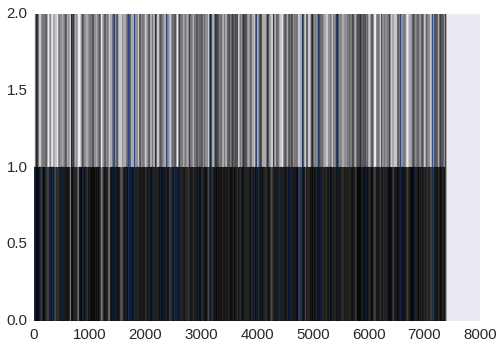

In [6]:
fault = df_all[(df_all.is_train == True)].fault_severity.astype(float)
n = len(fault)
plt.bar(np.arange(n), fault)
plt.show()

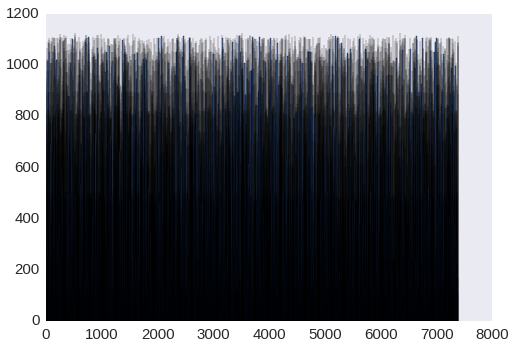

In [7]:
loc = df_train.location.astype(float)
plt.bar(np.arange(n), loc)
plt.show()

Both look like noise to me, gonna leave it for now. What about correlations among the various codes?

## Correlations

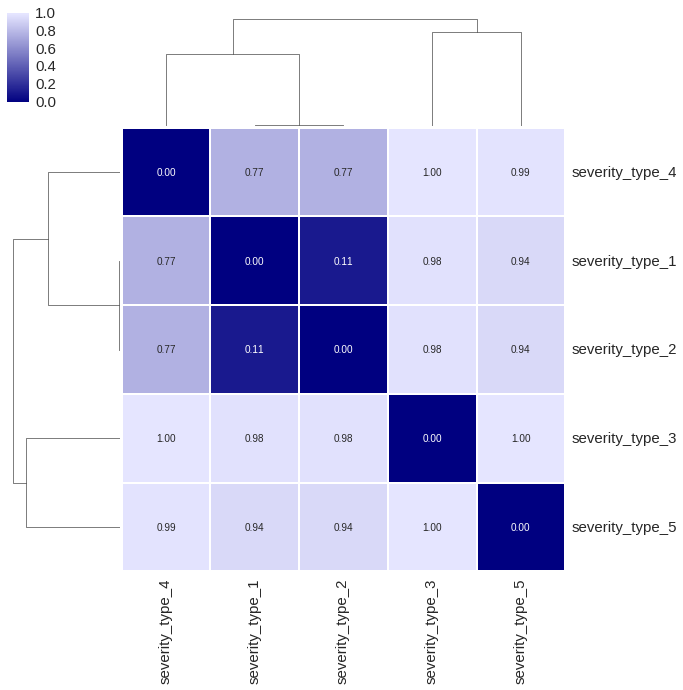

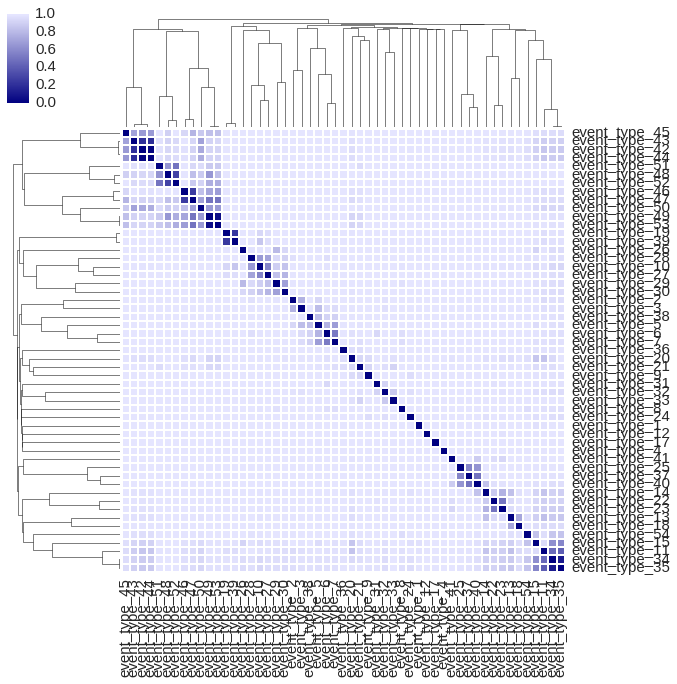

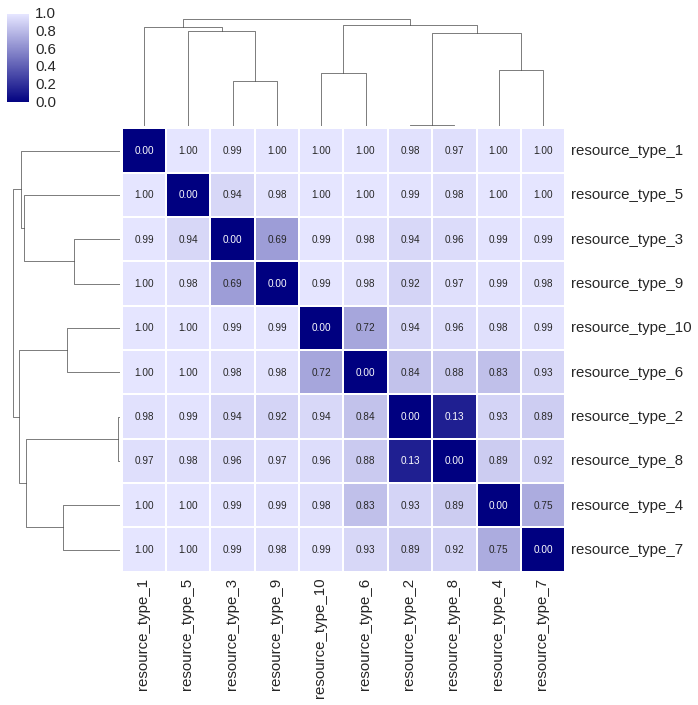

In [48]:
a = ['severity_type', 'event_type', 'resource_type']#, 'log_feature']
for b in a:

    # correlation matrix
    c = df_all.filter(regex=b).copy()
    corr = c.corr(min_periods=len(c.columns)/10)

    # colormap
    cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
    
    # clustered heatmap of distances w/o mask
    # dist 0 --> close, 1 --> distant
    dsim = 1.0-np.abs(corr)
    if len(dsim) > 10:
        annot=False
    else:
        annot=True
    g = sns.clustermap(data=dsim,
                       method='complete',
                       metric='correlation',
                       cmap=cmap, linewidths=0.5, vmin=0.0, vmax = 1.0,
                       annot=annot, fmt='.2f', annot_kws={'size':'10'})

In [51]:
# log_feature specific
c = df_all.filter(regex='log_feature').copy()
log_corr = c.corr(min_periods=len(c.columns)/10)
log_dsim = 1.0-np.abs(log_corr)

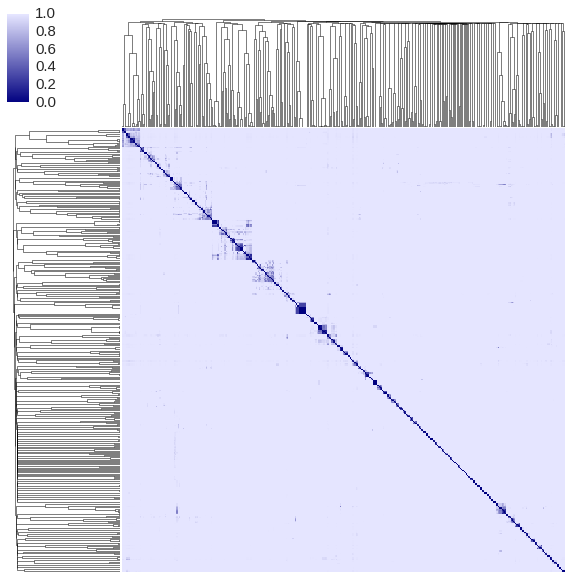

In [73]:
cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
g = sns.clustermap(data=log_dsim,
                   method='complete',
                   metric='correlation',
                   cmap=cmap,
                   xticklabels=False, yticklabels=False,
                   linewidths=0.0,
                   vmin=0.0,
                   vmax = 1.0)

The serverity types are mostly anti-correlated except type 1 and 2.

There is interesting structure in the resource and event types. Makes me more curious about how these events are networked, i.e. communicating to each other? Build out as network problem? Can't: id and loc are 1:1 so the only connections will be among events that are the same, in that they have the same coding across all types. I don't see that as informative to a model.

Log features are also clustered.

**But, this is clearly a well-defined classification problem.**

# Feature Engineering

* Data has complex multi-dimensional structure that ML algos know how to find and exploit to make decisions
* What's not exposed to the models?
    * How the various events are communicating. Fix == clustering
    * Time and location dependance of the events. Fix == ???
    * Events are too dense or too complex for the algo to find. Fix == dim reduction (PCA or SVD)
    * There is more attribute aggregation/creation needed. Fix == hyperattributes

## Feature Selection

Want to know what features may be the most important before any transformation. Try recursive feature elimination with cross-validation (RFECV). For multiclass, stratified K-fold used by default and shuffle is True.

LogisticRegression Optimal # features: 180


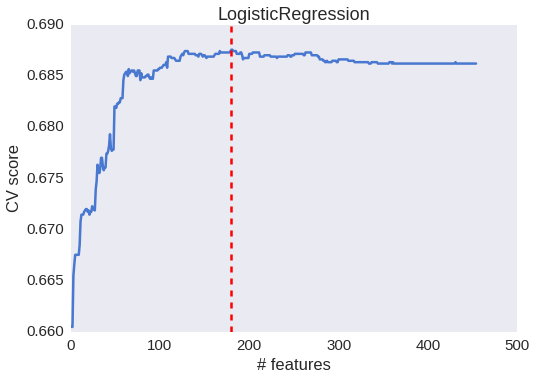

RandomForestClassifier Optimal # features: 319


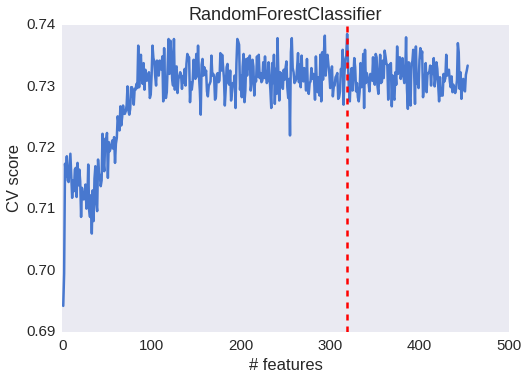

SGDClassifier Optimal # features: 221


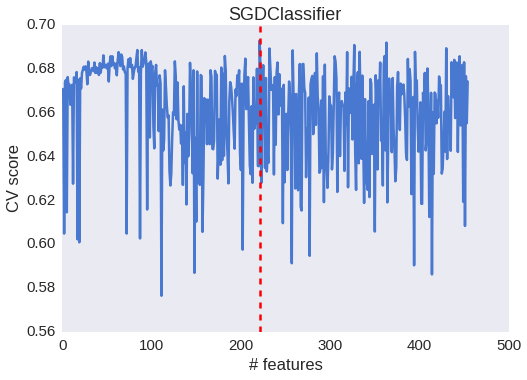

MultinomialNB Optimal # features: 450


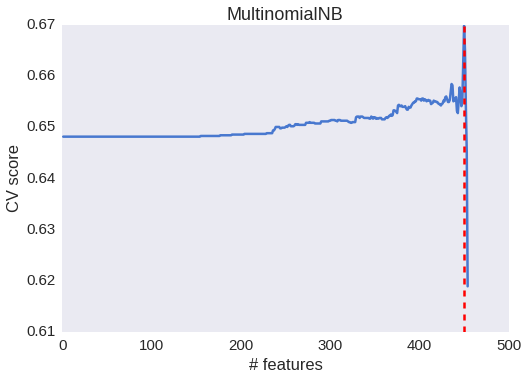

In [74]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.naive_bayes import MultinomialNB as MNB

# get training data
X = df_all[(df_all.is_train == True)].copy()
y = X.fault_severity
X.drop(drop, 1, inplace=True)

# make df to store results
df_frank = pd.DataFrame({'feature':X.columns.values})

# create base classifier
models =[]
models.append(LR(n_jobs=-1))
models.append(RF(n_jobs=-1))
models.append(SGD(n_jobs=-1))
models.append(MNB())

# iterate over models
for m in models:
    mname = str(m).split('(')[0]
    rfecv = RFECV(m, cv=3, scoring='accuracy')
    rfecv = rfecv.fit(X, y)
    print("%s Optimal # features: %d" % (mname, rfecv.n_features_))
    c = 'rfecv_'+str(mname[:3])
    df_frank[c] = rfecv.ranking_
    
    # n_features vs cv score
    plt.figure()
    plt.title(mname)
    plt.xlabel("# features")
    plt.ylabel("CV score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.axvline(rfecv.n_features_, color='r', linestyle='--')
    plt.show()

MNB is not a good model, nor SGD. Try SVC linear in their place.

In [ ]:
from sklearn.svm import SVC
m = SVC(kernel='linear')
mname = str(m).split('(')[0]
rfecv = RFECV(m, cv=3, scoring='accuracy')
rfecv = rfecv.fit(X, y)
print("%s Optimal # features: %d" % (mname, rfecv.n_features_))
c = 'rfecv_'+str(mname[:3])
df_frank[c] = rfecv.ranking_
    
# n_features vs cv score
plt.figure()
plt.title(mname)
plt.xlabel("# features")
plt.ylabel("CV score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.axvline(rfecv.n_features_, color='r', linestyle='--')
plt.show()

In [77]:
df_frank['avg_rank'] = df_frank.mean(axis=1)
df_frank.head()

## Dimension Reduction

The correlation matricies show there are redundant values. How many components in the full dataset to preserve? The eigenvalues in SVD should help determine what attributes are valuable. Clustering may be interesting too: could add cluster membership as a new feature. Data is sparse matrix of binary and multiclass values, options for analysis:
* [PCA or SVD](http://blog.applied.ai/visualising-high-dimensional-data/)
* [t-SNE](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)
* [Binary Jaccard similarity matrix fed into hierarchical cluster and then using the top "nodes"](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html)
* K-mode/median clustering
* [Cosine similarities fed into spectral clustering or dbscan](http://stackoverflow.com/questions/30089675/clustering-cosine-similarity-matrix)
* Frequent itemset mining

For k-means, see the odot ipynb, which isn't relevant here since this is categorical data (0/1) and Euclidean distance (used for clustering in k-menas) will be meaningless. **In hindsight, 'location' really fucks with the analysis. It appears to be meaningless, so I'm dumping it.**

### SVD

In [ ]:
# get rid of the cols that I suspect are not important
X = df_all.copy().drop(drop, 1)

# orig num comps
ncomps = X.shape[1] - 1

# run svd
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(X)

# print out variance ranges
for i in range(0, X.shape[1], 20):
    svar = svd_fit.explained_variance_ratio_.cumsum()[i]
    if svar >= 0.95:
        print('Variance preserved at {:} components == {:.1%}'.format(i, svar))

# plot result        
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line')

At 300 components 99% of variance is preserved, so try keeping just those in a new df.

In [ ]:
# transform X
ncomps = 300
X_svd = TruncatedSVD(n_components=ncomps).fit_transform(X)

# save svd to df and add back dropped cols
df_svd = pd.DataFrame(X_svd, columns=['svd{}'.format(c) for c in range(ncomps)], index=df_all.index)
for c in drop:
    df_svd[c] = df_all[c]

# save col names for easy filter later
svdcols = [c for c in df_svd.columns if c[:3] == 'svd']

# check size
assert(df_svd.shape[0] == df_all.shape[0])

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_svd', df_svd)
hdf.close()
call(["lrztar", "-zf", hdf_file])

Look at the variance matricies...

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities, _kl_divergence)
from scipy.spatial.distance import squareform, pdist

def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

# Pairwise distances between all data points.
D = pairwise_distances(df_svd[svdcols], squared=True)

# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)

# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)

# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

In [ ]:
# find all the factors of the matrix size to get round binning
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [ ]:
factors(D.shape[0])
binning = 12

plt.figure(figsize=(14, 11))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::binning, ::binning], interpolation='none', cmap=pal)
plt.title("Distance matrix")

plt.subplot(132)
plt.imshow(P_constant[::binning, ::binning], interpolation='none', cmap=pal)
plt.title("$p_{j|i}$ (constant $\sigma$)")

plt.subplot(133)
plt.imshow(P_binary_s[::binning, ::binning], interpolation='none', cmap=pal)
plt.title("$p_{j|i}$ (variable $\sigma$)")

### t-SNE

In [ ]:
# build tsne fitter
from sklearn.manifold import TSNE
#metric = metrics.pairwise.manhattan_distances
tsne = TSNE(n_components=2,
            #init='pca',
            #perplexity=50,
            #metric=metric,
            #learning_rate=500,
            method='barnes_hut',
            verbose=2)

# fit training data only
Z = tsne.fit_transform(df_svd[svdcols])

# save to df
df_tsne = pd.DataFrame(Z, columns=['x','y'], index=df_svd.index)
for c in drop:
    df_tsne[c] = df_svd[c]

# check size
assert(df_tsne.shape[0] == df_svd.shape[0])

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_tsne', df_tsne)
hdf.close()
call(["lrztar", "-zf", hdf_file])

In [ ]:
# plot the result
mpl_fig = plt.figure()
sns.regplot(df_tsne['x'],
            df_tsne['y'],
           fit_reg=False,
           scatter=True,
           scatter_kws={"c": df_tsne['fault_severity'],
                        "cmap": plt.cm.jet,
                        "label": df_tsne['fault_severity']}
           )
plt.title('t-SNE')
plt.xlabel('p1')
plt.ylabel('p2')
py.iplot_mpl(mpl_fig, strip_style=True)

This is disappointing. No obvious groups in the SVD reduced data

## Clustering

### DBScan

In [ ]:
# remove the log_feature features which are scaled volumes
ecols = [c for c in df_all.columns if 'log_feature' not in c]
X = df_all.copy()[ecols]
X = X[(X.is_train == True)].drop(drop, 1)

In [ ]:
# base similarity matrix
similarity = np.dot(X, X.T)

# squared magnitude of preference vectors (number of occurrences)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity
cosine = similarity * inv_mag
cosine = cosine.T * inv_mag

In [ ]:
# find whole factors for matrix
factors(cosine.shape[0])

In [ ]:
# plot it
binning = 11
plt.figure(figsize=(14, 11))
cmap = sns.light_palette("blue", as_cmap=True)
plt.imshow(cosine[::binning, ::binning], interpolation='none', cmap=cmap)

In [ ]:
# dbscan expects distances, so need 1-cosine input
from sklearn.cluster import DBSCAN
dbclust = DBSCAN(min_samples=30, eps=0.6).fit_predict(1.0-cosine)

In [ ]:
# viz the cluster dist
from collections import Counter
for i in Counter(dbclust).items():
    print i
sns.distplot(dbclust, kde=False)

### K-modes

In [ ]:
from kmodes import kmodes

# build the clusters
km = kmodes.KModes(n_clusters=22, init='Cao', n_init=5, verbose=1)
clusters = km.fit_predict(X)

# viz the cluster dist
for i in Counter(clusters).items():
    print i
sns.distplot(clusters, kde=False)

That's not a terrible result, it somewhat mimics the tsne result, except for bins 3 and 4, as I don't see any isolated points in tsne, but it's not a 1:1 comparison. Let's see how this performs. First add the cluster assignments to the X matrix.

### Hierarchical

revisit the correlation measures
run a hierarch model

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster

# create dist matrix
Y = 1.0 - np.abs(df_svd.corr())
Z = linkage(Y, 'complete', 'correlation')

# check cophenetic coeffs; closer to 1, the better
c, coph_dists = cophenet(Z, Y)
print c

# view dendro
dendro = dendrogram(z, labels=Y.columns)
plt.show()

In [ ]:
k = 2
clusters = fcluster(Z, k, criterion='maxclust')
plt.figure(figsize=(14, 11))
plt.scatter(df_svd[:, 0], df_svd[:, 1], c=clusters, cmap='prism')
plt.show()

Check validity of clusters using permutation tests

In [ ]:
# create permutation
svm = SVC(kernel='linear')
cv = StratifiedKFold(y, 2)
score, permutation_scores, pvalue = permutation_test_score(
    svm, X, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=-1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

# histo of permu scores
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

### Picking Cluster Membership

In [ ]:
# append cluster membership to the no-location version of X
a = np.array(clusters)[np.newaxis]
print 'X no loc ', X_nl.shape
X_nlc = np.concatenate((X_nl, a.T), axis=1)
print 'X no loc+clu ', X_nlc.shape

# Algorithm Evaluation

## Theano

In [ ]:
#quick existing model test
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
thno.config.compute_test_value = 'warn'

# common vars
batch_size = 128
nb_epoch = 20
dims = X.shape[1]

# rebuild the train and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

# NN model and layers
model = Sequential()
model.add(Dense(512, input_shape=(dims,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
model.add(Activation('softmax'))
rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms)

# fit the model
model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          show_accuracy=True,
          verbose=2,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test,
                       show_accuracy=True,
                       verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## XGBoost

In [169]:
# get train inputs
X_train = df_all[(df_all.is_train == True)].copy()
y_train = X_train.fault_severity
X_train.drop(drop, 1, inplace=True)

# get test inputs
X_test = df_all[(df_all.is_train == False)].copy()
X_test.drop(drop, 1, inplace=True)

# split train into... train and test
from sklearn.cross_validation import train_test_split
xg_train, xg_test, yg_train, yg_test = train_test_split(X_train, y_train, test_size=0.33)

In [170]:
import xgboost as xgb

xg_train = xgb.DMatrix(xg_train, label=yg_train.values)
xg_test = xgb.DMatrix(xg_test, label=yg_test.values)

In [178]:
nclass = 3
param = {}
param = {'max_depth': 0,
         'eta': 0.0,
         'gamma': 0.0,
         #'alpha': 0,
         #'lambda': 1,
         'objective': 'multi:softprob',
         'num_class': nclass,
         #'eval_metric': 'mlogloss',
         'silent': True}

In [190]:
num_round = 1000
best_perr = 1.0
for gamma in (0, 0.5, 1):
    for depth in range(2, 10, 2):
        for eta in np.arange(0.02, 0.2, 0.02):
            param['max_depth'] = depth
            param['eta'] = eta
            param['gamma'] = gamma
            bst = xgb.train(param, xg_train, num_round)
            yg_prob = bst.predict(xg_test).reshape(yg_test.shape[0], nclass)
            yg_label = np.argmax(yg_prob, axis=1)
            perr = sum(int(yg_label[i]) != yg_test.values[i] for i in
                       range(len(yg_test.values))) / float(len(yg_test.values))
            print "Gamma: %.3f, Depth: %d, Eta: %.3f, Err: %.3f" % (gamma, depth, eta, perr)
            if perr < best_perr:
                print '**** NEW BEST *****'
                best_perr = perr
                best_depth = depth
                best_eta = eta
                best_gamma = gamma
print "Best Pred. %.3f (Depth %d, Eta %.3f, Gamma %.3f)" % (best_perr, best_depth, best_eta, best_gamma)
param['max_depth'] = best_depth
param['eta'] = best_eta
param['gamma'] = best_gamma

Gamma: 0.000, Depth: 2, Eta: 0.020, Err: 0.251
**** NEW BEST *****
Gamma: 0.000, Depth: 2, Eta: 0.040, Err: 0.243
**** NEW BEST *****
Gamma: 0.000, Depth: 2, Eta: 0.060, Err: 0.236
**** NEW BEST *****
Gamma: 0.000, Depth: 2, Eta: 0.080, Err: 0.234
**** NEW BEST *****
Gamma: 0.000, Depth: 2, Eta: 0.100, Err: 0.235
Gamma: 0.000, Depth: 2, Eta: 0.120, Err: 0.233
**** NEW BEST *****
Gamma: 0.000, Depth: 2, Eta: 0.140, Err: 0.236
Gamma: 0.000, Depth: 2, Eta: 0.160, Err: 0.241
Gamma: 0.000, Depth: 2, Eta: 0.180, Err: 0.241
Gamma: 0.000, Depth: 4, Eta: 0.020, Err: 0.236
Gamma: 0.000, Depth: 4, Eta: 0.040, Err: 0.238
Gamma: 0.000, Depth: 4, Eta: 0.060, Err: 0.238
Gamma: 0.000, Depth: 4, Eta: 0.080, Err: 0.236
Gamma: 0.000, Depth: 4, Eta: 0.100, Err: 0.241
Gamma: 0.000, Depth: 4, Eta: 0.120, Err: 0.245
Gamma: 0.000, Depth: 4, Eta: 0.140, Err: 0.243
Gamma: 0.000, Depth: 4, Eta: 0.160, Err: 0.251
Gamma: 0.000, Depth: 4, Eta: 0.180, Err: 0.249
Gamma: 0.000, Depth: 6, Eta: 0.020, Err: 0.238
Gamma: 

KeyboardInterrupt: 

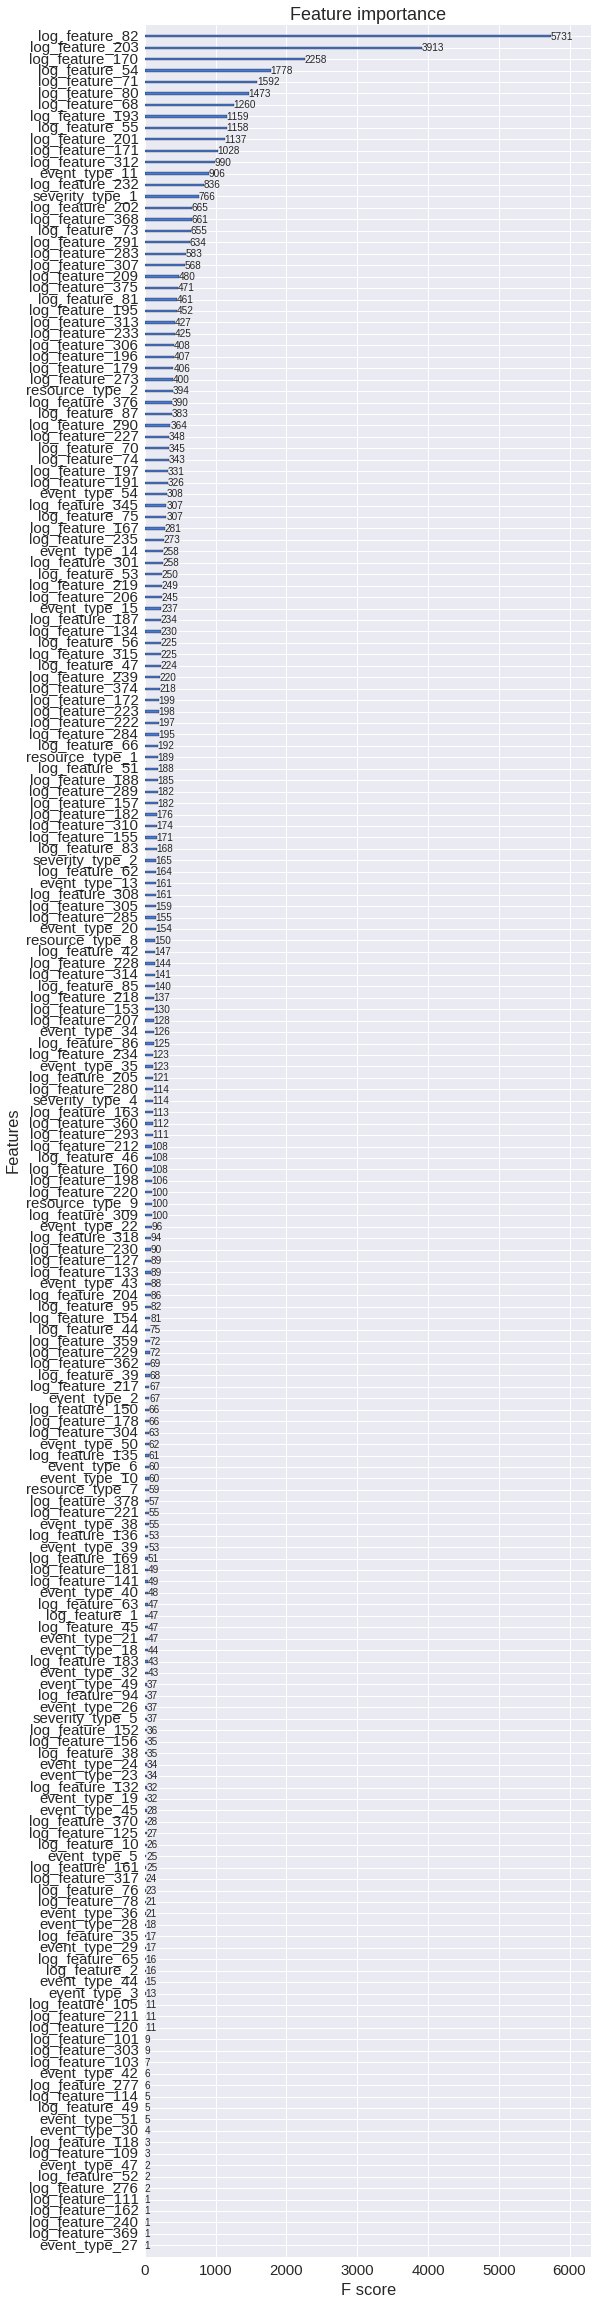

In [191]:
f, ax = plt.subplots(figsize=(8,40))
xgb.plot_importance(bst, ax=ax)
#xgb.to_graphviz(bst, num_trees=2)

In [104]:
X_train = xgb.DMatrix(X_train, label=y_train.values)
bst = xgb.train(param, X_train, num_round)

X_test = xgb.DMatrix(X_test)
y_pred = bst.predict(X_test)

In [107]:
dtest = df_all[(df_all.is_train == False)].copy()
with open("submission.csv", "w") as f:
    f.write("id,predict_0,predict_1,predict_2\n")
    for i, item in enumerate(ypred):
        f.write(str(int(dtest.id.iloc[i])) + "," + ",".join(map(lambda x:str(x), item)) + "\n")

In [ ]:
x_train_xgb = x_train.as_matrix()
y_train_xgb = y_train.as_matrix()

model = xgb.XGBClassifier()
model.fit(x_train_xgb, y_train_xgb)

y_probs = model.predict_proba(x_test.as_matrix())
print(y_probs)

final = [[iden,(y_probs[j][0]),(y_probs[j][1]),(y_probs[j][2])] for j,iden in enumerate(testUniqueIds)]
frame = pd.DataFrame(final,columns=('id','predict_0','predict_1','predict_2'))
frame.to_csv("submission.csv",index=False)

## Scikit

Going to build test harness of test, train, and validation splits using KFolding. Then run predicitions for each fold. Also want to keep track of true positive rate (tpr) and false positive rate (fpr) so I can evaluate receiving operating characteristic curves (ROC's) and the associated area under the curve (AUC) of each. I will also plot the confusion matrix for each model to visualize the predicitve results.

### Test Harness

Define the cross-validation and confusion matrix helper functions.

In [ ]:
# build a cross-validation function
def run_cv(X, y, clf_class, **kwargs):
    kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)
    y_pred = y.copy()
    mean_acc = 0.0
    mean_prec = 0.0
    mean_recl = 0.0
    mean_f1 = 0.0
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
        mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
        mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
        mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
        mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
    mean_acc /= len(kf)
    mean_recl /= len(kf)
    mean_prec /= len(kf)
    mean_f1 /= len(kf)
    return y_pred, mean_acc, mean_prec, mean_recl, mean_f1

def draw_confusion_matrices(confusion_matrices, class_names):
    labels = list(class_names)
    for cm in confusion_matrices:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm[1])
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.title('%s' % cm[0])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        for i,j in ((x,y) for x in xrange(len(cm[1])) for y in xrange(len(cm[1][0]))):
            val = '{:.1%}'.format(cm[1][i][j]/cm[1].sum())
            ax.annotate(str(val), xy=(i,j), color='white', ha="center", va="center")
        plt.show()

### Models

Loading up a bunch of standard machine learning algorithms into test harness. This is a classification problem, so let's try the standard models...

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF

ml_models = []
ml_models.append(["Support Vector", SVC, {'verbose':1}])
ml_models.append(["Logistic Regression", LR, {'multi_class':'multinomial',
                                              'solver':'lbfgs',
                                              'verbose':1}])
ml_models.append(["Naive Bayes", NB, {'verbose':1}])
ml_models.append(["Decision Trees", DT, {'verbose':1}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2,
                                        'n_jobs':-1,
                                        'verbose':1}])

### Measure Performance

Show me the accuracy (acc), precision (prec), recall (recl), confusion matrix (cm), and mean auc for each model. 

**TODO:**
* Gut check accuracy for equivalence:
    ```python
    metrics.jaccard_similarity_score(y_true, y_pred) == metrics.accuracy_score(y_true, y_pred)
    metrics.classification_report(y, y_pred)
    metrics.confusion_matrix(y, y_pred)
    ``` 

In [ ]:
# process each model
models = []
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    models.append(m[0])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

# plot confusion matricies
draw_confusion_matrices(cms, np.unique(y))

In [ ]:
models_df = pd.DataFrame.from_items([('model', models),
                              ('accuracy', acc),
                              ('precision', prec),
                              ('recall', recl),
                              ('f1', f1)
                              ])
models_df.sort(['accuracy', 'precision', 'recall', 'f1'], ascending=[False, False, False, False])

### Testing Results

Find which of the harness models has performed the best in the first pass.

In [ ]:
# best and worst models
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])

max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])

max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

Random forest is the obvious winner by all measures, so let's take a crack at tuning that model.

### Algorithm Tuning

#### Question: What are the important features in the model?

In [ ]:
# feature importance
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True, random_state=4)
y_pred = y.copy()

# keep values for all features
feat_impt = {}
for f in features:
    feat_impt[f] = []

# go through all features    
for train_index, test_index in kf:
    clf = RF(n_estimators=50, min_samples_split=2, n_jobs=-1)
    X_train, X_test = X.ix[train_index], X.ix[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        feat_impt[features[indices[f]]].append(importances[indices[f]])

for k in feat_impt:
    val = np.mean(feat_impt[k])
    std = np.std(feat_impt[k])
    feat_impt[k] = val

In [ ]:
# sort the features by importance
sorted_feat = sorted(feat_impt.items(), key=operator.itemgetter(1))
sorted_feat.reverse()

# bookkeeping
cumper = 0.
nbr = False

# make a copy of original dataframe to drop unneeded features
X_keep = X.copy()

# print out importances
print "item -- feature -- weight -- cumm_weight"
for i, k in enumerate(sorted_feat):
    cumper += k[1]
    
    # tell me when we hit 90% of weights
    if (nbr is False and cumper >= 0.95):
        print '**----  Reached 95%  ----**'
        nbr = True
    print i, k[0], '{:.1%}'.format(k[1]), '{:.0%}'.format(cumper)
    
    # drop unneeded features
    if nbr is True:
        X_keep = X_keep.drop(k[0], axis=1)

In [ ]:
features_keep = X_keep.columns

# checks
print "\n%d observations of %d features" % X_keep.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features_keep)

Re-run the ML test harness for RF only and see if the model improves (below is cut and paste of earlier code)

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'n_estimators':72,
                                        'min_samples_split':9,
                                        'n_jobs':-1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_keep, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

* RF predictive power got worse when features contributing < 10% weight were dropped.
* **RF predictive power got better when features contributing < 5% weight were dropped.**

#### Question: What model has best calibration and discrimination?

Calibration measures the difference between actual and predicted probability for individual groups. Discrimination measures the difference between model predictions and the baseline probability. Equations are taken from [Yang, Yates, and Smith (1991)](http://psychology.huji.ac.il/.upload/Ilan/YanivYatesSmith1991PB.pdf).

In [ ]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)
    y_prob = np.zeros((len(y), 3))
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

def calibration(prob, outcome,n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    c = 0.0
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        predicted_prob = np.mean(prob[in_bin])
        true_bin_prob = np.mean(outcome[in_bin])
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob, outcome, n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    d = 0.0
    base_prob = np.mean(outcome)
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [ ]:
print "Lower calibration and higher discrimination are preferred..."

ml_models = []
#ml_models.append(["XGBoost", XGBC, {'max_depth':3, 'n_estimators':300, 'learning_rate':0.05}])
#ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["Linear Logistic Regression", LR, {'multi_class':'multinomial',
                                                     'solver':'lbfgs'}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2, 'n_jobs':-1}])

cal_err = []
discrim = []
for m in ml_models:
    print "\n"+m[0]
    pred_prob = run_prob_cv(X, y, m[1], **m[2])
    churn_prob, is_churn = pred_prob[:,1], y == 1
    cal_err.append(calibration(churn_prob, is_churn))
    discrim.append(discrimination(churn_prob,is_churn))
    print '{:20} {:.4f}'.format("Calibration Error", cal_err[-1])
    print '{:20} {:.4f}'.format("Discrimination", discrim[-1])
    
idx, value = min(enumerate(cal_err), key=operator.itemgetter(1))
print '{:20} {:20} {:.3%}'.format('\nBest calibration error:', ml_models[idx][0], cal_err[idx])
idx, value = max(enumerate(discrim), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best discrimination:', ml_models[idx][0], discrim[idx])

#### Question: Can we tune the model params to get better results?

In [ ]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
clf = RF(n_jobs=-1)
param_grid = {"n_estimators":[50, 75, 100],
              "max_depth": [None, 3],
              "max_features": [None, 'auto'],
              "min_samples_split": [4, 9],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
gs = grid_search.GridSearchCV(clf, param_grid=param_grid)
start = time()
gs.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs.grid_scores_)))
report(grid_search.grid_scores_)

**Best scores using X (took 542.40 seconds for 32 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}


**Best scores using X_keep (took 471.68 seconds for 48 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'bootstrap': True,
                                        'min_samples_leaf': 1,
                                        'n_estimators': 500,
                                        'min_samples_split': 4,
                                        'criterion': 'entropy',
                                        'max_features': 'auto',
                                        'max_depth': None,
                                        'n_jobs': -1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

**This model is hardly better than the initial guess, but it's technically simpler, so I'll run with this one.**

In [ ]:
# Use 10 estimators so predictions are all multiples of 0.1
m = (["Random Forest", RF, {'bootstrap': True,
                            'min_samples_leaf': 1,
                            'n_estimators': 10,
                            'min_samples_split': 1,
                            'criterion': 'entropy',
                            'max_features': 'auto',
                            'max_depth': None,
                            'n_jobs': -1}])
pred_prob = run_prob_cv(X, y, m[1], **m[2])
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

In [ ]:
from ggplot import *
baseline = np.mean(is_churn)
ggplot(counts, aes(x='pred_prob',y='true_prob',size='count')) + \
        geom_point(color='blue') + \
        stat_function(fun = lambda x: x, color='red') + \
        stat_function(fun = lambda x: baseline, color='green') + \
        xlim(-0.05,  1.05) + \
        ylim(-0.05,1.05) + \
        ggtitle("Random Forest") + \
        xlab("Predicted probability") + ylab("Relative frequency of outcome")

# Final Model

In [ ]:
some_clf = final_clf_name(final params)

some_clf.fit(X_train, y_train)

X_test = df_test.copy().drop(unwanted cols)

prob = some_clf.predict_proba(X_test)

df_result = pd.DataFrame({
        'id': df_test.loc[:, 'id'].values,
        'predict_0': prob[:, 0],
        'predict_1': prob[:, 1],
        'predict_2': prob[:, 2]})

df_result.to_csv('submission.csv', index=False)

In [ ]:
# save to hdf5 file
hdf = pd.HDFStore(hdf_file)
hdf.put('df_result', df_result)
hdf.close()
call(["lrztar", "-zf", hdf_file])

# Ad Hoc Junk

In [ ]:
# build random forest
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
n_trials = 100
test_size_percent = 0.1

# build labels
sig_field = 'sms_count'
signals = df[[c for c in df.columns if c != sig_field]]
labels = df[sig_field]

# test train split
plot_data = []
for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
                                                            signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
    thresholds = np.append(thresholds, 1)
    queue_rate = []  
    for threshold in thresholds:  
        queue_rate.append((predictions >= threshold).mean())
        
    # save plot data
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })
    
# plot model
uniform_thresholds = np.linspace(0, 1, 101)
uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

uniform_payout_plots = []
n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)
    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")

print '{0:.0f}'.format(np.max(median_payout))

# Scratch Space